Run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Locating the path to the project

In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Pred_Main/Predictive_Maintenance_Bearings/data/CWRU/DE48k/raw'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.getcwd())

/content


Change to your desired working directory

In [ ]:
os.chdir('/content/drive')
print(os.getcwd())
working_path = 'Predictive_Maintenance_Bearings'
cwd = os.path.join('My Drive', working_path)
os.chdir(cwd)
print(os.getcwd())

/content/drive
/content/drive/.shortcut-targets-by-id/1dQ0SyMX5Mk4O3VYZTVDtczeXzKCyl0sI/Predictive_Maintenance_Bearings


Pip install required packages

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

# Command to install pyts into colab environment
!pip install pyts


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.1 MB/s eta 0:00:00


Import packages required for this file and set the default figure size

In [ ]:
import torch
import matplotlib.pyplot as plt
import random
import time
import math
import pandas as pd
import numpy as np
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['font.size'] = 16

Use this cell to ensure cuda is available on colab.

In [ ]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings')

Good to go!


Read the normal drive end data for the generation of Markov Transition Field images. Data for all the 4 bearings captured for normal operation is in this csv file. Currently only using B1 for developing the model.

In [ ]:
GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/Predictive_Maintenance_Bearings/data/ims_data'
print(GOOGLE_DRIVE_PATH)

/content/drive/MyDrive/Predictive_Maintenance_Bearings/data/ims_data


In [ ]:
import pandas as pd
GOOGLE_DRIVE_PATH = 'data/ims_data/2nd_test/2nd_test'
print(GOOGLE_DRIVE_PATH)
path = os.path.join(os.getcwd(), GOOGLE_DRIVE_PATH)
print(os.getcwd())
print(path)
print(os.listdir(path))

data = pd.DataFrame()
for file in os.listdir(path):
  dataset = pd.read_csv(os.path.join(path, file), sep = '\t', header = None)
  data = pd.concat([data, dataset[0]])

print(data.shape)

# data.to_csv(f'{GOOGLE_DRIVE_PATH}/bearing_ims')


data/ims_data/2nd_test/2nd_test
/content/drive/.shortcut-targets-by-id/1dQ0SyMX5Mk4O3VYZTVDtczeXzKCyl0sI/Predictive_Maintenance_Bearings
/content/drive/.shortcut-targets-by-id/1dQ0SyMX5Mk4O3VYZTVDtczeXzKCyl0sI/Predictive_Maintenance_Bearings/data/ims_data/2nd_test/2nd_test
['2004.02.12.11.52.39', '2004.02.12.13.12.39', '2004.02.12.13.02.39', '2004.02.12.12.52.39', '2004.02.12.10.52.39', '2004.02.12.12.22.39', '2004.02.12.13.22.39', '2004.02.12.11.22.39', '2004.02.12.10.32.39', '2004.02.12.11.42.39', '2004.02.12.12.12.39', '2004.02.12.11.02.39', '2004.02.12.12.02.39', '2004.02.12.10.42.39', '2004.02.12.11.32.39', '2004.02.12.12.32.39', '2004.02.12.11.12.39', '2004.02.12.12.42.39', '2004.02.12.16.02.39', '2004.02.12.13.32.39', '2004.02.12.17.02.39', '2004.02.12.14.42.39', '2004.02.12.17.22.39', '2004.02.12.17.32.39', '2004.02.12.18.02.39', '2004.02.12.14.02.39', '2004.02.12.15.22.39', '2004.02.12.15.02.39', '2004.02.12.14.22.39', '2004.02.12.13.52.39', '2004.02.12.18.12.39', '2004.02.12.

The code below generates the Markov Transition Field for every 224 data points. The code is written in the mtf_data.py file. Data is re-sized to 1089 as the fields generated by the rest are 0 zeros and do not provide valuable information.

Need to load the .mat files

In [ ]:
import scipy.io
mat = scipy.io.loadmat(f'data/CWRU/DE48k/raw/{mat_files[4]}')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X111_DE_time', 'X111_FE_time', 'X111RPM'])


Separate the .mat files between DE(data) and FE(df)

In [ ]:
# print(mat)
# del mat['__header__']
# del mat['__version__']
# del mat['__globals__']
# del mat['X146RPM']
print(mat.keys())
for key in mat.keys():
  print(len(mat[key]))
  if 'DE' in key:
    data = pd.DataFrame(mat[key])
  elif 'FE' in key:
    df = pd.DataFrame(mat[key])

print(data.head())
print(df.head())


Count the amount of failures

In [ ]:
data_file_path = 'data/CWRU/DE12k/raw'
count_outer = 0
count_inner = 0
count_healthy = 0
count_ball = 0
file_unknown = 0
for file in os.listdir('data/CWRU/DE12k/raw'):
  if 'outer' in file:
    count_outer += 1 
  elif 'inner' in file:
    count_inner += 1
  elif 'healthy' in file:
    count_healthy += 1  
  elif 'ball' in file:
    count_ball += 1
  else:
    file_unknown += 1 


print('total_files:', len(os.listdir('data/CWRU/DE12k/raw')))
print('out_faults:', count_outer)
print('inner_faults:', count_inner)
print('healthy:', count_healthy)
print('ball_faults:', count_ball)
print('unknown:', file_unknown)

print('Count Total:', count_outer + count_inner + count_healthy + count_ball + file_unknown)

total_files: 65
out_faults: 27
inner_faults: 17
healthy: 4
ball_faults: 16
unknown: 1
Count Total: 65


In [ ]:
data_file = os.listdir('data/CWRU/DE12k/raw')[32]
import scipy.io
mat = scipy.io.loadmat(f'data/CWRU/DE12k/raw/{data_file}')
for key in mat.keys():
  print(len(mat[key]))
data = pd.DataFrame(mat['X209_DE_time'])
print(data.head())
df = pd.DataFrame(mat['X209_FE_time'])
print(df.head())
# df1 = pd.DataFrame(mat['X146_BA_time'])
# print(df1.head())

Convert the raw data in Markov Transition Fields 

In [ ]:
x = data.to_numpy()
print(x.shape)
from Back.mtf_data import MTF_Generator

mtf = MTF_Generator()

mtf.raw_data(x.squeeze())

fields = mtf.create_fields()

Doule check the mtf's (Batches, Hight, Width)

In [ ]:
print(fields.shape)

(409, 500, 500)


Visually check the files

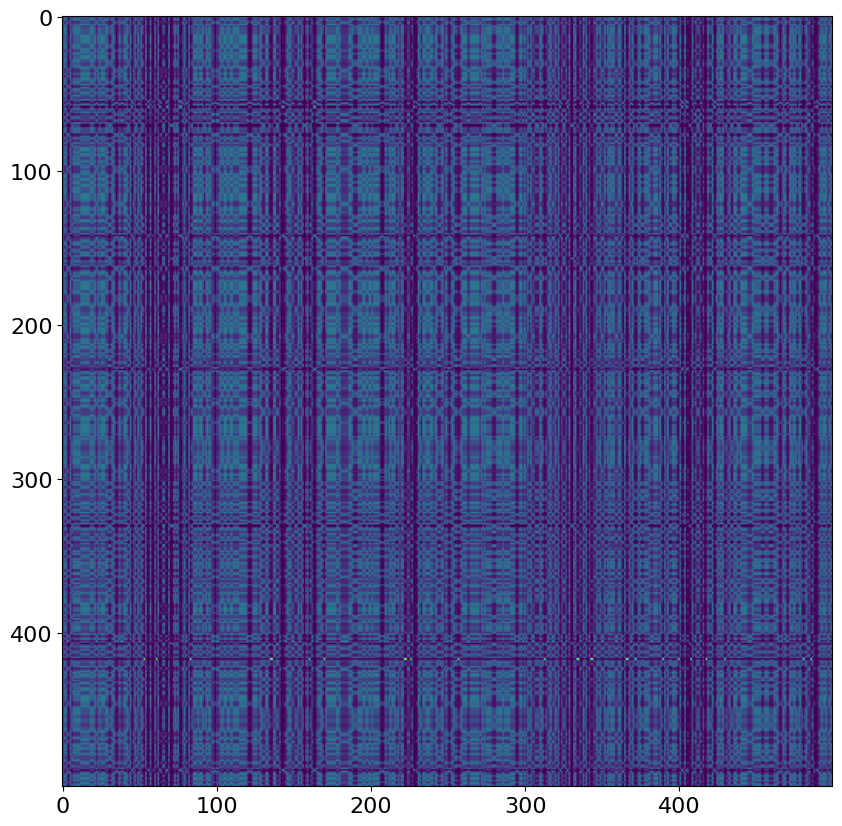

In [ ]:
import matplotlib.pyplot as plt
data_img = fields[2]
imgplot = plt.imshow(data_img)
plt.show()

Separate into the test, train, split

In [ ]:
print(fields.shape)
t = int(fields.shape[0])
num_test = int(t * .7)
num_train = int(t * .3 *.85) 
num_val = int(t*.3 - num_train )

print('Number of test:', num_test)
print('Number of train:', num_train)
print('Number of val:', num_val)
print('Total:', num_test + num_train + num_val)

test_data = fields[:369]
train_data = fields[369: 369+36 ]
val_data = fields[369+36: 369+36+4]

# 50/50
# train_data = train_data[:40]
# val_data = val_data[:4]
# test_data = test_data[:36]
print('-----------')
print('separated data')

print('Number of test:', test_data.shape)
print('Number of train:', train_data.shape)
print('Number of val:', val_data.shape)

Change Directory so when images are generated they are automaticly save into the 

In [ ]:
print(os.getcwd())
new_path = 'data/ims_data/data'
# print(os.listdir(new_path))
path_of_healthy_data = os.path.join(os.getcwd(), new_path) 
path_of_data = os.path.join(os.getcwd(), new_path) 
print(path_of_data)
print(os.listdir(path_of_data))

/content/drive/.shortcut-targets-by-id/1dQ0SyMX5Mk4O3VYZTVDtczeXzKCyl0sI/Predictive_Maintenance_Bearings
/content/drive/.shortcut-targets-by-id/1dQ0SyMX5Mk4O3VYZTVDtczeXzKCyl0sI/Predictive_Maintenance_Bearings/data/ims_data/data
['Test', 'Val', 'Train']


/content/drive/.shortcut-targets-by-id/1dQ0SyMX5Mk4O3VYZTVDtczeXzKCyl0sI/Predictive_Maintenance_Bearings/data/ims_data/data


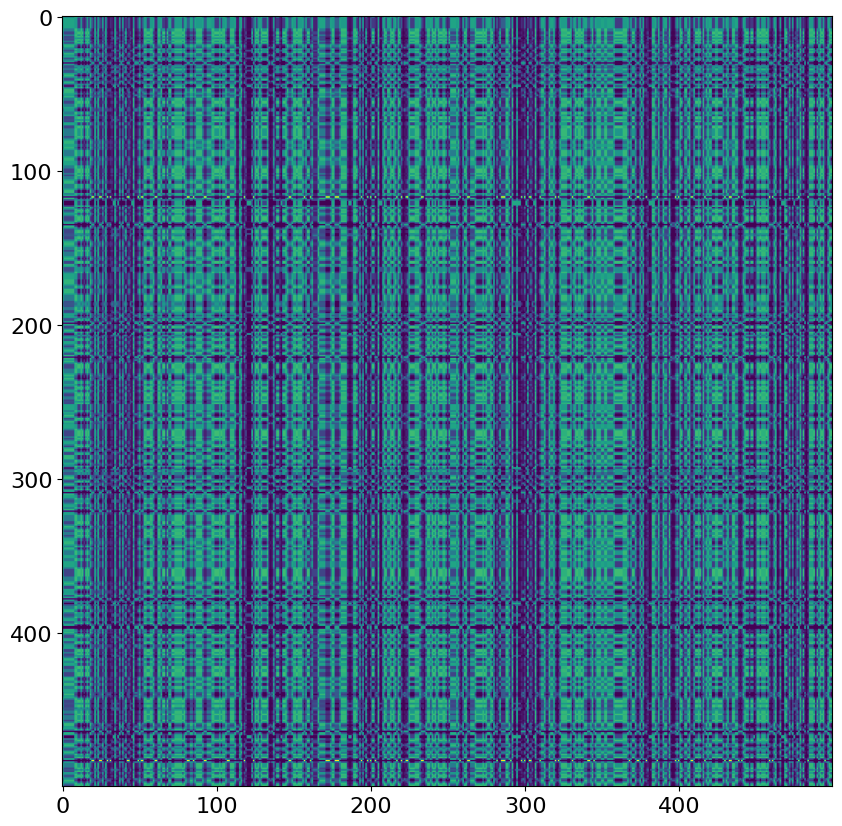

In [ ]:
import matplotlib.pyplot as plt
print(path_of_data)
data_img = test_data[5]
imgplot = plt.imshow(data_img)
plt.show()

#
type_of_data = None
data_to_use = None

for j in range(3):
  if j == 0:
    type_of_data = 'Test' 
    data_to_use = test_data
  elif j == 1:
    type_of_data = 'Train'
    data_to_use = train_data
  if j == 2:
    type_of_data = 'Val'
    data_to_use = val_data
  
  for i in range(data_to_use.shape[0]):
    plt.imsave(os.path.join(path_of_data, f'{type_of_data}/Faulty/{i}.png'), data_to_use[i], vmin=0., vmax = 1.)

In [ ]:
# print(f'{path_of_data}/Train/Healthy')
print('Healthy Files:', len(os.listdir(f'{path_of_healthy_data}/Train/Healthy')))
print('Faulty Files:', len(os.listdir(f'{path_of_data}/Train/Faulty')))

print('Healthy Files:', len(os.listdir(f'{path_of_healthy_data}/Test/Healthy')))
print('Faulty Files:', len(os.listdir(f'{path_of_data}/Test/Faulty')))

print('Healthy Files:', len(os.listdir(f'{path_of_healthy_data}/Val/Healthy')))
print('Faulty Files:', len(os.listdir(f'{path_of_data}/Val/Faulty')))

Healthy Files: 36
Faulty Files: 36
Healthy Files: 369
Faulty Files: 369
Healthy Files: 4
Faulty Files: 4
